Initialization of the $XX$ Ising chain with 0 magnetic field.

In [ ]:
import numpy as np
from tqdm import tqdm

In [45]:
from lib.quantum_ising_chain import QuantumIsingChain1D

In [46]:
N=100
J=2
h=0

def build_hopping_hamiltonian(N):
    """
    Build the Hamiltonian for a 1D $XX$ Ising chain with zero magnetic field of N sites with periodic boundary conditions.
    
    Args:
        N (int): Number of sites in the chain.
    
    Returns:
        H (np.ndarray): The Hamiltonian matrix.
    """
    H = np.zeros((N, N), dtype=complex)
    for i in range(N):
        H[i, (i + 1) % N] = -1/2  
        H[(i + 1) % N, i] = -1/2  
    return H

H = build_hopping_hamiltonian(N)

In [47]:
xx_ising_chain_no_magnetic_field = QuantumIsingChain1D(N=N, J=J, h=h, H=H)

Computation of the numerical evolution with the formula
$$
    \Gamma(t) = e^{iHt} \Gamma(0) e^{-iHt}
$$

In [48]:
def gamma_0(N):   
    """
    Construct a $\Gamma(0)$ taking as the initial state the Neel state.

    Args:
        N (int): Number of sites in the chain.
    
    Returns:
        neel_state (np.ndarray): $\Gamma(0)$.
    """
    gamma_0 = np.zeros((N, N), dtype=complex)
    for i in range(1, N, 2):  
        gamma_0[i, i] = 1
    return gamma_0

initial_gamma = gamma_0(N)

---
---

Computation of $\Gamma(t)$ using the formula
$$
    \Gamma_{jk}(t) = \frac{\delta_{jk}}{2} + \frac{(-1)^j}{2} (i)^{|{k-j}|} J_{|{k-j}|}(2Jt)
$$

In [49]:
from scipy.special import jv

In [50]:
def compute_theoretical_gamma_large_N(N, t_init, t_final, t_step, J,disable_tqdm=False):
    """
    Compute the full Gamma(t) matrix for large N at each time step.
    Args:
        N (int): Number of sites.
        t_init (float): Initial time.
        t_final (float): Final time.
        t_step (float): Time step.
        disable_tqdm (bool): Disable progress bar.

    Returns:
        gamma_t_series (numpy.ndarray): np.array of $\Gamma(t)$ for each time step (3D array).
        Jt_values (numpy.ndarray): Array of time points.
    """
    # Time values
    Jt_values = J * np.arange(t_init, t_final + t_step, t_step)
    
    # Compute distance matrix |j - k| for all indices
    indices = np.arange(1, N + 1)  # Indices start from 1 to N
    delta = np.abs(indices[:, None] - indices)  # |j - k| as a matrix
    
    # Precompute phase matrix (-1)^j * (-1j)^delta
    phase = (-1)**indices[:, None] * (-1j)**delta

    gamma_matrices = []
    
    # Loop over time steps 
    for Jt in tqdm(Jt_values, desc="Computing Theoretical Gamma",disable=disable_tqdm):
        # Diagonal elements (delta == 0)
        gamma_diag = 0.5 + 0.5 * (-1)**indices * jv(0, 2 * Jt)
        
        # Non-diagonal elements (delta > 0)
        gamma_non_diag = 0.5 * phase * jv(delta, 2 * Jt)
        gamma_non_diag[delta == 0] = gamma_diag  # Replace diagonal elements
        
        gamma_matrices.append(gamma_non_diag)
    
    gamma_t_series = np.array(gamma_matrices)

    return gamma_t_series, Jt_values

---
---

Function to plot the numerical evolution and the theoretical evolution.

In [51]:
import matplotlib.pyplot as plt

In [52]:
def plot_comparison_covariance_matrix_ij(gamma_t_theoretical, gamma_t_numerical, t_values, row, col):
    """
    Plot the real and imaginary parts of the theoretical and numerical covariance matrix elements.

    Args:
        gamma_t_theoretical (list): Theoretical time-evolved covariance matrix.
        gamma_t_numerical (list): Numerical time-evolved covariance matrix.
        t_values (numpy.ndarray): Array of time points.
        row (int): Row index of the covariance matrix element.
        col (int): Column index of the covariance matrix element.
    """
    gamma_real_theoretical = [gamma_t[row-1, col-1].real for gamma_t in gamma_t_theoretical]
    gamma_real_numerical = [gamma_t[  row-1, col-1].real for gamma_t in gamma_t_numerical]
    gamma_imag_theoretical = [gamma_t[row-1, col-1].imag for gamma_t in gamma_t_theoretical]
    gamma_imag_numerical = [gamma_t[  row-1, col-1].imag for gamma_t in gamma_t_numerical]
    plt.figure(figsize=(14, 6))

    plt.plot(t_values,gamma_real_theoretical, label=r"$\mathfrak{R}(\Gamma^{\mathrm{Theoretical}}_{%d,%d})$" % (row, col), color="blue",linestyle="--")
    plt.plot(t_values,gamma_real_numerical, label=r"$\mathfrak{R}(\Gamma^{\mathrm{Numerical}}_{%d,%d})$" % (  row, col),linewidth=2,alpha=0.5, color="red")
    plt.plot(t_values,gamma_imag_theoretical, label=r"$\mathfrak{I}(\Gamma^{\mathrm{Theoretical}}_{%d,%d})$" % (row, col), color="blue", linestyle="--")
    plt.plot(t_values,gamma_imag_numerical, label=r"$\mathfrak{I}(\Gamma^{\mathrm{Numerical}}_{%d,%d})$" %   (row, col), linewidth=2,alpha=0.5,color="red")
    plt.title(r"$\Gamma_{%d,%d}$ Over Time" % (row, col))
    plt.xlabel("$Jt$")
    plt.ylabel(r"$\Gamma_{%d,%d}(Jt)$" % (row, col))
    plt.legend()
    plt.grid(True)

---
---

Comparison between $\Gamma(t)$ numerical and theoretical

In [53]:
t_init = 0
t_final = 30
t_step = 0.05

In [63]:
gamma_t_numerical , Jt_values = xx_ising_chain_no_magnetic_field.compute_time_evolution_covariance_matrix(t_init,t_final,t_step,initial_gamma)





Computing Numerical Evolution: 100%|██████████| 301/301 [00:00<00:00, 611.82it/s]


In [ ]:
gamma_t_theoretical , Jt_values = compute_theoretical_gamma_large_N(N, t_init, t_final, t_step, J)

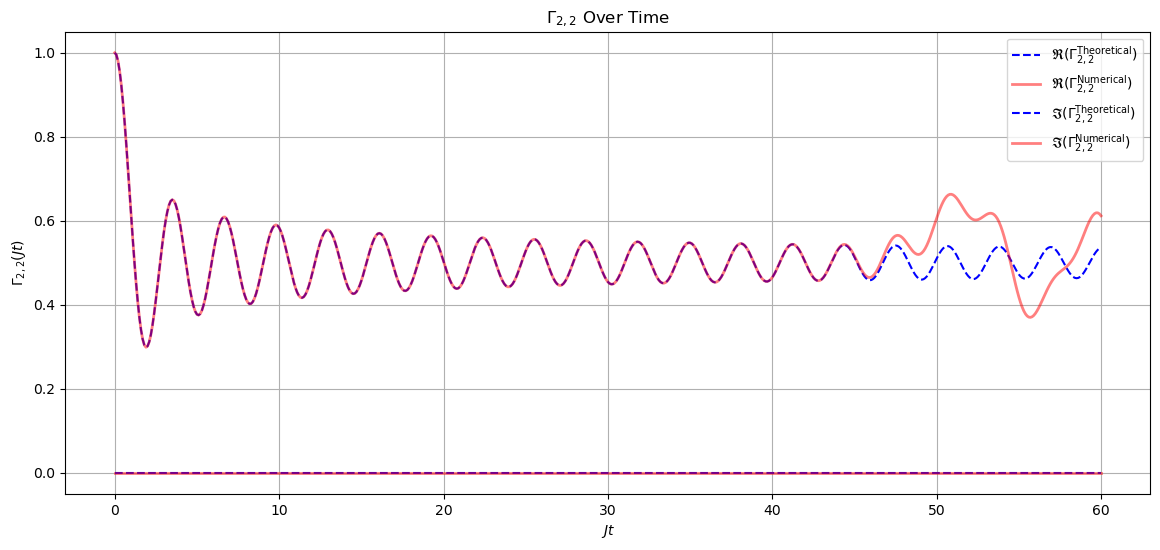

In [56]:
plot_comparison_covariance_matrix_ij(gamma_t_theoretical, gamma_t_numerical, Jt_values, 2,2)

We observe that exist a value $Jt_{critical}$ such that, for $Jt>Jt_{critical}$ the two simulations don't match. This is due to finite size effect. 

---
---

Computation of the dependence of $Jt_{critical}$ with the system size $N$.

In [57]:
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [58]:
def compute_divergence_time(N_intial,N_final,N_step, t_init, t_final, t_step, J, threshold,row,col):
    """
    Compute the special value of Jt where theoretical and numerical results diverge.
    Parameters:
        N_values : list of matrix sizes
        t_init, t_final : time range
        t_step : step size for time
        J : hopping parameter
        threshold : divergence threshold for relative error
    Returns:
        critical_times : list of critical Jt values for each N
    """
    critical_times = []

    N_values = np.arange(N_intial, N_final, N_step)

    for N in tqdm(N_values, desc="Processing N values"):
        # Compute theoretical Gamma
        gamma_theoretical, Jt_values = compute_theoretical_gamma_large_N(N, t_init, t_final, t_step, J,disable_tqdm=True)
        
        # Compute numerical Gamma
        initial_state = gamma_0(N)
        xx_ising_chain_no_magnetic_field = QuantumIsingChain1D(N=N, J=J, h=0, H=build_hopping_hamiltonian(N))
        gamma_numerical, _ = xx_ising_chain_no_magnetic_field.compute_time_evolution_covariance_matrix(t_init, t_final, t_step, initial_state ,disable_tqdm=True)
        
        # Compute the divergence time
        for t_idx, (gamma_th, gamma_num) in enumerate(zip(gamma_theoretical, gamma_numerical)):
            rel_diff = np.abs((gamma_th[row,col] - gamma_num[row,col]) )
            if rel_diff > threshold:
                critical_times.append(Jt_values[t_idx])
                break
        else:
            critical_times.append(np.nan)  # No divergence found within the range

    return critical_times , N_values

In [ ]:
threshold = 0.01
N_initial = 50
N_final=100
N_step=10
t_init = 0
t_final = 30
t_step = 0.1
J=10

# Compute the critical times
critical_Jt, N_values = compute_divergence_time(N_initial,N_final,N_step, t_init, t_final, t_step, J, threshold,2,2)

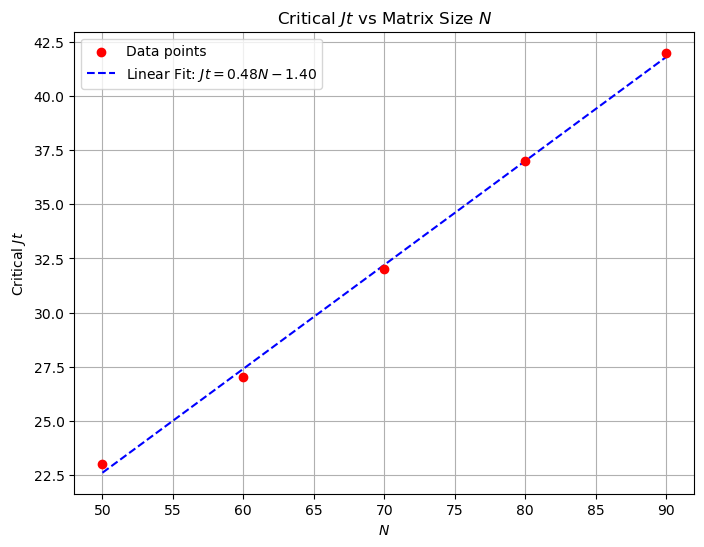

Linear Fit Parameters: Slope (a) = 0.480, Intercept (b) = -1.400


In [60]:
N_values_reshaped = N_values.reshape(-1, 1)  # Reshape for sklearn
model = LinearRegression()
model.fit(N_values_reshaped, critical_Jt)
a = model.coef_[0]  # Slope
b = model.intercept_  # Intercept

# Generate a smooth line for the linear fit
N_fit = np.linspace(min(N_values), max(N_values), 500)
Jt_fit = a * N_fit + b

# Plot the data points and the linear fit
plt.figure(figsize=(8, 6))
plt.scatter(N_values, critical_Jt, color='red', label='Data points', zorder=5)
plt.plot(N_fit, Jt_fit, color='blue', linestyle='--', label=f'Linear Fit: $Jt = {a:.2f}N {b:.2f}$')
plt.title("Critical $Jt$ vs Matrix Size $N$")
plt.xlabel("$N$")
plt.ylabel("Critical $Jt$")
plt.legend()
plt.grid(True)
plt.show()

print(f"Linear Fit Parameters: Slope (a) = {a:.3f}, Intercept (b) = {b:.3f}")